In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import math

PATH = r"../../Data/completeLoad.csv"
df = pd.read_csv(PATH)
df_h = df.set_index(['zone_id', 'year', 'month', 'day'])

Using TensorFlow backend.
/home/raphael/anaconda3/envs/MAP573/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/raphael/anaconda3/envs/MAP573/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/raphael/anaconda3/envs/MAP573/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/raphael/ana

In [2]:
#
unfolded_df = {}
for i, x in enumerate(tqdm(df_h.columns.tolist())):
    col_tuple = df_h[x].to_dict()
    for j, k in col_tuple.items():
        unfolded_df[tuple(list(j) + [i+1])] = k

n_df = pd.DataFrame.from_dict(unfolded_df, orient="index").sort_index()
m_index = pd.MultiIndex.from_tuples(unfolded_df.keys())
#multi index dataframe
#blocks of each day (keeping zone year month day and variating hour) 
mi_df = pd.DataFrame(unfolded_df.values(), m_index).sort_index()

100%|██████████| 24/24 [00:00<00:00, 24.97it/s]


In [3]:
# convert pd.DateFrame to np.array of type float and group by zone. mi_df to df_zone
df_zone = np.array([mi_df.loc[(i+1)].values.astype("float32").reshape(
        len(mi_df.loc[(i+1)]),) for i in range(mi_df.index[-1][0])])

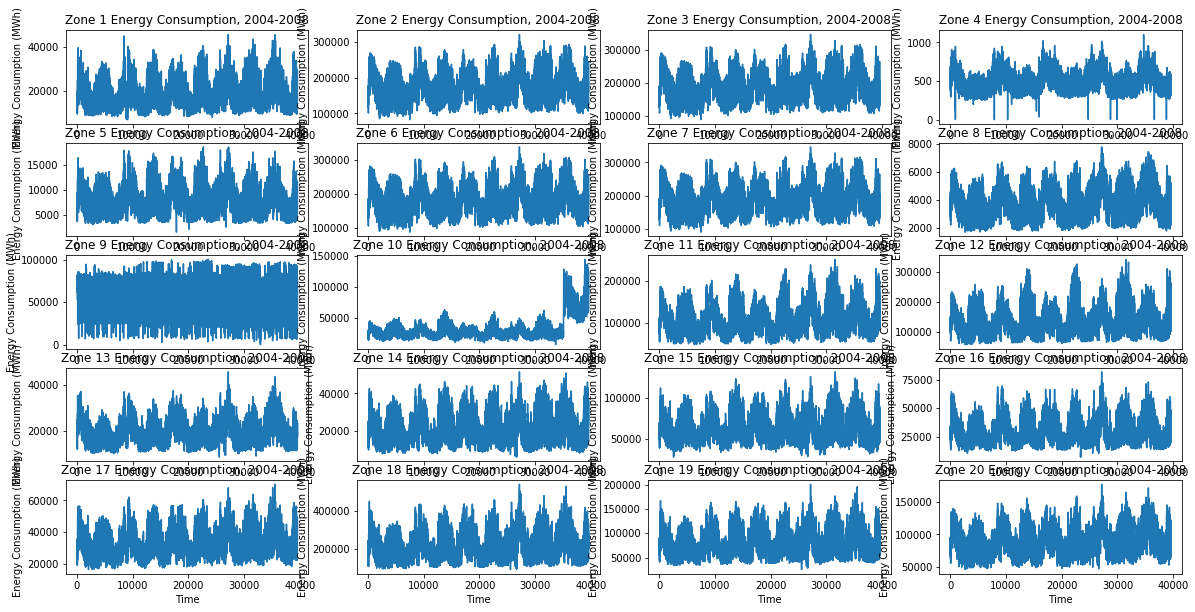

In [4]:
plt.figure(figsize = (20, 10))
for i, x in enumerate(df_zone):
    plt.subplot(5, 4, i+1)
    plt.plot(x)
    plt.xlabel("Time")
    plt.ylabel("Energy Consumption (MWh)")
    plt.title("Zone {} Energy Consumption, 2004-2008".format(i+1))
plt.show()

In [5]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LSTM, Bidirectional
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from keras import callbacks
import pydot

In [6]:
# use data for zone 1.
data = df_zone[0].reshape(-1, 1)

# normalize data with min max normalization.
normalizer = MinMaxScaler(feature_range = (0, 1))
dataset = normalizer.fit_transform(data)

# Using 80% of data for training, 20% for validation.
TRAINING_PERC = 0.80

train_size = int(len(dataset) * TRAINING_PERC)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of samples training set: " + str((len(train))))
print("Number of samples test set: " + str((len(test))))

Number of samples training set: 31660
Number of samples test set: 7916


In [50]:
# helper function to read data.
def create_dataset_nstep_train(dataset, window_size = 1, nstep = 1):
    data_x, data_y = [], []
    for i in range(len(dataset) - window_size - nstep - 1):
        ws_2 = int(window_size/2)
        s1 = dataset[i:(i + ws_2), 0]
        s2 = dataset[(i + ws_2 + nstep):(i + window_size + nstep), 0]
        data_x.append(np.concatenate((s1, s2)))
        data_y.append(dataset[(i + ws_2):(i + ws_2 + nstep), 0])
    return(np.array(data_x), np.array(data_y))


def create_dataset_nstep_test(dataset, window_size = 1, nstep = 1):
    data_x, data_y = [], []
    for i in range(0,len(dataset) - window_size - nstep - 1, window_size + nstep):
        ws_2 = int(window_size/2)
        s1 = dataset[i:(i + ws_2), 0]
        s2 = dataset[(i + ws_2 + nstep):(i + window_size + nstep), 0]
        data_x.append(np.concatenate((s1, s2)))
        data_y.append(dataset[(i + ws_2):(i + ws_2 + nstep), 0])
    return(np.array(data_x), np.array(data_y))


def create_model_nstep(train_X, train_Y, window_size = 1, nstep = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(Bidirectional(LSTM(50,input_shape = (1, window_size), return_sequences=True)))
    vanilla_rnn.add(Bidirectional(LSTM(50,input_shape = (1, window_size), return_sequences=True)))
    vanilla_rnn.add(Bidirectional(LSTM(50,input_shape = (1, window_size), )))
    vanilla_rnn.add(Dense(nstep))
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam")
    
    return(vanilla_rnn)

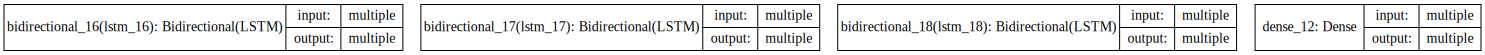

In [59]:
window_size, nstep =  24 * 7 * 4, 24 * 7  
train_X, train_Y = create_dataset_nstep_train(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep_test(test, window_size, nstep)

train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))

In [60]:
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 100, verbose = 2, validation_split=0.15, callbacks=[es])
# plot_history(history)

Train on 26196 samples, validate on 4623 samples
Epoch 1/100
 - 15s - loss: 0.0169 - val_loss: 0.0108
Epoch 2/100
 - 6s - loss: 0.0069 - val_loss: 0.0098
Epoch 3/100
 - 5s - loss: 0.0064 - val_loss: 0.0104
Epoch 4/100
 - 5s - loss: 0.0061 - val_loss: 0.0091
Epoch 5/100
 - 5s - loss: 0.0059 - val_loss: 0.0099
Epoch 6/100
 - 5s - loss: 0.0058 - val_loss: 0.0094
Epoch 7/100
 - 5s - loss: 0.0055 - val_loss: 0.0092
Epoch 8/100
 - 5s - loss: 0.0053 - val_loss: 0.0092
Epoch 9/100
 - 5s - loss: 0.0050 - val_loss: 0.0095
Epoch 00009: early stopping


In [61]:
def get_predict_and_score(model, X, Y):
    # transform the prediction to the original scale.
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability.
    orig_data = normalizer.inverse_transform(Y)
    # calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data[:, 0], pred[:, 0]))
    return(score, pred)
#     return pred

mse_train, train_predict = get_predict_and_score(vanilla_rnn, train_X, train_Y)
mse_test, test_predict = get_predict_and_score(vanilla_rnn, test_X, test_Y)

print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)

# train_predict = get_predict_and_score(vanilla_rnn, train_X, train_Y)
# test_predict = get_predict_and_score(vanilla_rnn, test_X, test_Y)


Training data error: 1844.86 MSE
Test data error: 1343.48 MSE


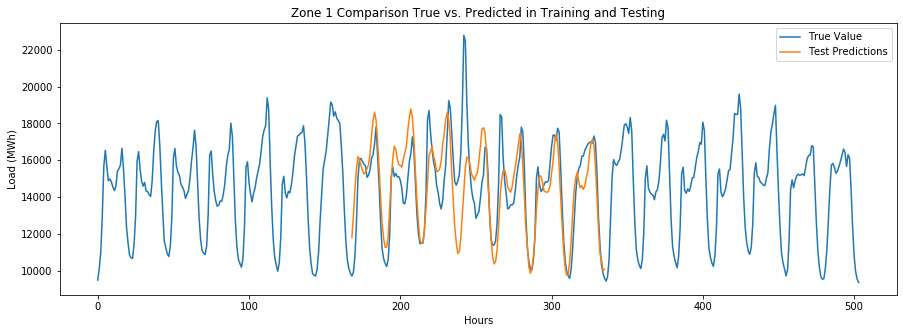

In [71]:
# Training predictions.
# train_predictions = np.empty_like(dataset)
train_predictions = np.zeros(train_predict.shape[0]*train_predict.shape[1]).reshape(train_predict.shape[0],train_predict.shape[1])
train_predictions[0:len(train_predict) + window_size + nstep, :] = train_predict

# Test predictions.
test_predictions = np.empty_like(dataset)
# test_predictions = np.zeros(test_predict[0].shape[0]*test_predict[0].shape[1]).reshape(test_predict[0].shape[0],test_predict[0].shape[1])
test_predictions[:, :] = np.nan

ws_2 = int(window_size/2)
j = 0
auxi = 0
for i in range(train_size,len(dataset) - window_size - nstep - 1, window_size + nstep):
    test_predictions[i + ws_2:i + ws_2 + nstep] = test_predict[j].reshape(nstep, 1)
    j += 1
    if j == 70:
        auxi = i
        break


# # Create the plot.
# plt.figure(figsize = (15, 5))
# plt.plot(normalizer.inverse_transform(dataset)[train_size  + ws_2 - nstep: train_size + ws_2 + 2 * nstep], label = "True Value")
# # plt.plot(train_predictions, label = "Training Predictions")
# plt.plot(test_predictions[train_size + ws_2 - nstep: train_size + ws_2 + 2 * nstep], label = "Test Predictions")
# plt.xlabel("Hours")
# plt.ylabel("Load (MWh)")
# plt.title("Zone 1 Comparison True vs. Predicted in Training and Testing")
# plt.legend()
# plt.show()
i = 7
n = window_size + nstep
plt.figure(figsize = (15, 5))
plt.plot(normalizer.inverse_transform(dataset)[train_size + i * n + ws_2 - nstep: train_size + i * n + ws_2 + 2 * nstep], label = "True Value")
# plt.plot(train_predictions, label = "Training Predictions")
plt.plot(test_predictions[train_size + i * n + ws_2 - nstep: train_size + i * n + ws_2 + 2 * nstep], label = "Test Predictions")
plt.xlabel("Hours")
plt.ylabel("Load (MWh)")
plt.title("Zone 1 Comparison True vs. Predicted in Training and Testing")
plt.legend()
plt.show()